In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.utils import plotting_neuronal_behavioural, prep_data, preprocess_data, plot_latent_timeseries, plot_phase_space, rotating_plot
from src.data_loading import DatabaseStimuli
from src.bundlenet import BunDLeNet, train_model
import tensorflow as tf
import os
os.chdir('../..')
os.getcwd()

'/Users/aksheykumar/Desktop/BunDLe-Net'

In [2]:
from src.utils import plotting_neuronal_behavioural, prep_data, preprocess_data, plot_latent_timeseries, plot_phase_space, rotating_plot


In [3]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

## Load Data (excluding behavioural neurons)

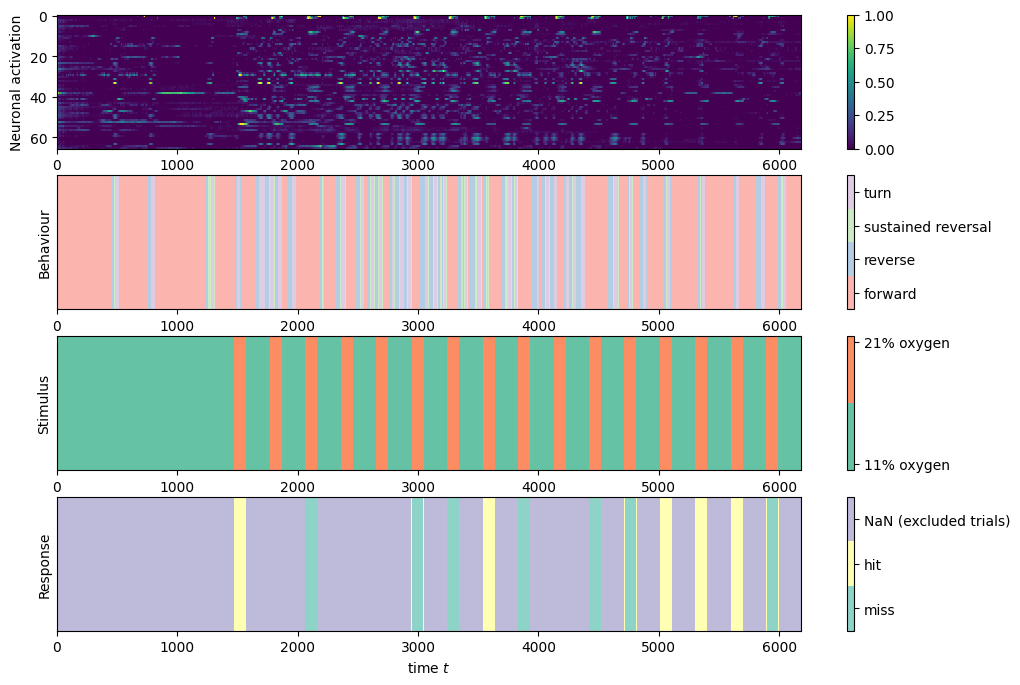

In [4]:
worm_num = 6
b_neurons = [
    'AVAR',
    'AVAL',
]
data = DatabaseStimuli(data_set_no=worm_num)
data.exclude_neurons(b_neurons)
X = data.neuron_traces.T
B = data.states
S = data.stimulus
R = data.response
algorithm = 'BunDLeNet'

plotting_neuronal_behavioural(X, B, data.state_names, S, data.stimulus_names, R, data.response_names, vmin=0, vmax=1)

## Preprocess data and embed with BunDLe-Net

In [5]:
XnS = np.c_[X, S/21.]
XnS.shape, X.shape

((6181, 67), (6181, 66))

In [158]:
### Preprocess and prepare data for BundLe Net
#time, X = preprocess_data(X, data.fps)
X_, B_ = prep_data(X, B, win=5)
X_, S_ = prep_data(X, S, win=5)
X_, R_ = prep_data(X, R, win=5)

### Deploy BunDLe Net
model = BunDLeNet(latent_dim=3)
model.build(input_shape=X_.shape)
model.tau = tf.keras.Sequential([
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dense(30, activation='relu'),
    layers.Dense(25, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(3, activation='linear'),
    layers.Normalization(axis=-1), 
    layers.GaussianNoise(0.01)
])
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

loss_array = train_model(
    X_,
    R_,
    model,
    optimizer,
    gamma=0.9, 
    n_epochs=500,
    pca_init=False,
    best_of_5_init=False
)

Losses 0.000308 0.000047 0.000356: 100%|██████████████| 500/500 [00:28<00:00, 17.66it/s]


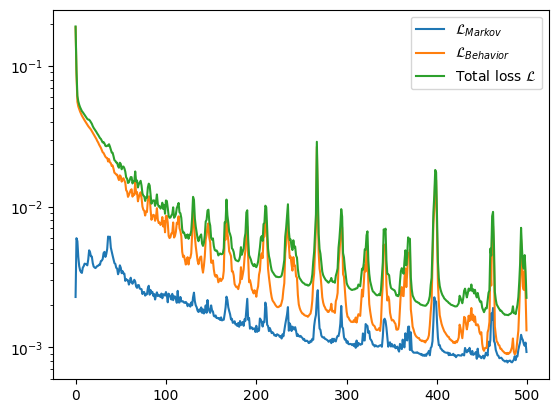

In [159]:
# Training losses vs epochs
plt.figure()
for i, label in  enumerate(["$\mathcal{L}_{{Markov}}$", "$\mathcal{L}_{{Behavior}}$","Total loss $\mathcal{L}$" ]):
    plt.semilogy(loss_array[:,i], label=label)
plt.legend()
plt.show()

## Projecting into latent space

In [190]:
Y0_ = model.tau(X_[:,0]).numpy()

### Save the weights
save_generated_data = True
if save_generated_data:
    model.save_weights('data/generated/BunDLeNet_model_worm_' + str(worm_num))
    np.savetxt('data/generated/saved_Y/Y0__R_runs' + algorithm + '_worm_' + str(worm_num), Y0_)
    np.savetxt('data/generated/saved_Y/B__R_runs' + algorithm + '_worm_' + str(worm_num), B_)
    np.savetxt('data/generated/saved_Y/S__R_runs' + algorithm + '_worm_' + str(worm_num), S_)
    np.savetxt('data/generated/saved_Y/R__R_runs' + algorithm + '_worm_' + str(worm_num), R_)

In [14]:
load_generated_data=True
if load_generated_data:
    Y0_ = np.loadtxt('data/generated/saved_Y/Y0__R_runs' + algorithm + '_worm_' + str(worm_num))
    B_ = np.loadtxt('data/generated/saved_Y/B__R_runs' + algorithm + '_worm_' + str(worm_num)).astype(int)
    S_ = np.loadtxt('data/generated/saved_Y/S__R_runs' + algorithm + '_worm_' + str(worm_num)).astype(int)
    R_ = np.loadtxt('data/generated/saved_Y/R__R_runs' + algorithm + '_worm_' + str(worm_num)).astype(int)

In [15]:
B_

array([1, 1, 1, ..., 1, 1, 1])

## Visualising embedding

In [16]:
Y0_.shape, B_.shape, S_.shape, R_.shape

((6176, 3), (6176,), (6176,), (6176,))

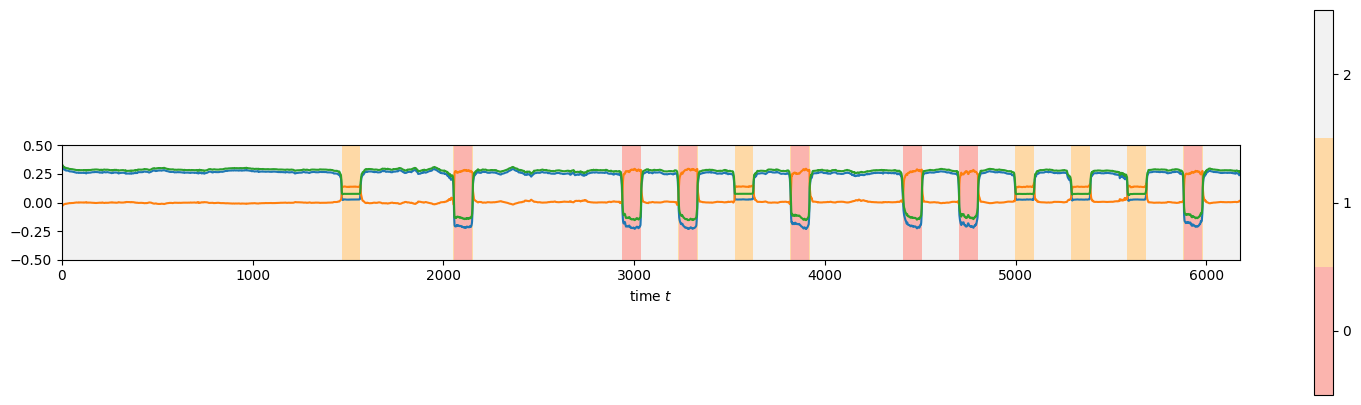

In [17]:
plot_latent_timeseries(Y0_, R_, data.response_names)

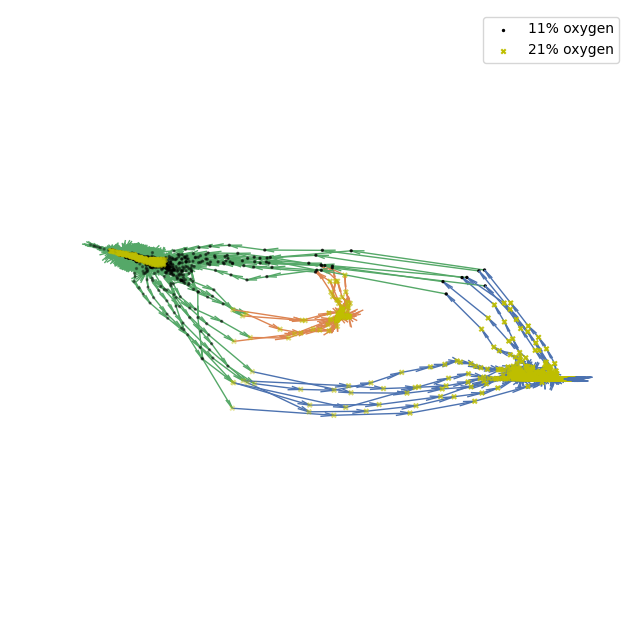

In [28]:
elev, azim = -50., 50.
#plot_phase_space(Y0_[1000:2500], R_[1000:2500], data.response_names, legend=True, elev=elev, azim=azim)
#plot_phase_space(Y0_, R_, data.response_names, legend=True, elev=elev, azim=azim)
fig, ax = plot_phase_space(Y0_[:], R_[:], data.response_names, legend=True, elev=elev, azim=azim)
ax.scatter(Y0_[S_==11,0], Y0_[S_==11,1], Y0_[S_==11,2], marker='o', c='k', s=2, label="11% oxygen")
ax.scatter(Y0_[S_==21,0], Y0_[S_==21,1], Y0_[S_==21,2], marker='x', c='y', s=10, label="21% oxygen")
ax.legend()
plt.show()

In [180]:
def plot_phase_space(Y, B, state_names, show_points=False, legend=True, **kwargs):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.view_init(**kwargs)
    plot_ps_(fig, ax, Y=Y, B=B, state_names=state_names, show_points=show_points, legend=legend)
    return fig, ax

In [173]:
S_

array([11, 11, 11, ..., 11, 11, 11], dtype=uint8)

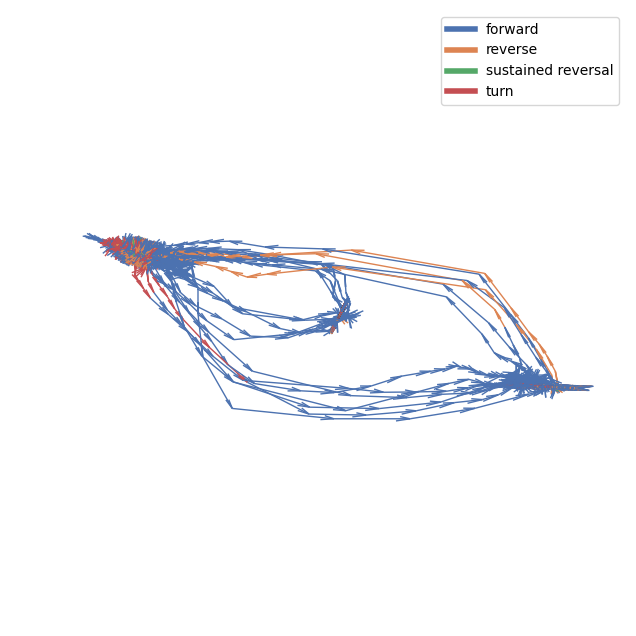

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [167]:
plot_phase_space(Y0_, B_, data.state_names, legend=True, elev=elev, azim=azim)

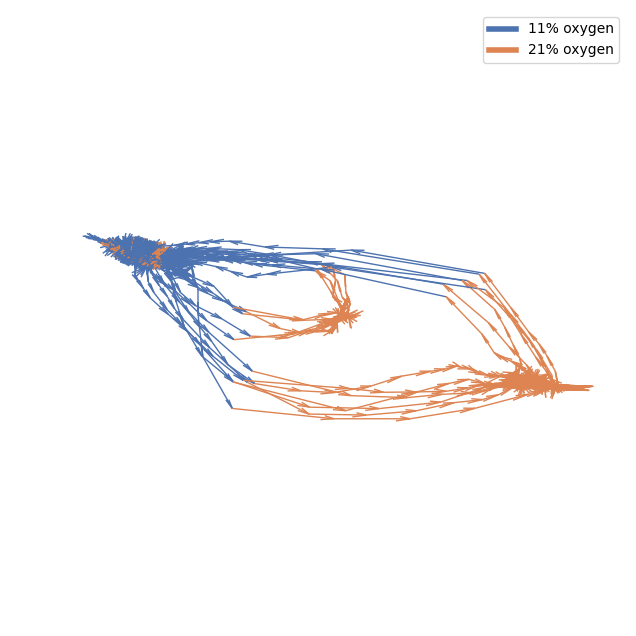

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [168]:
plot_phase_space(Y0_, S_, data.stimulus_names, legend=True, elev=elev, azim=azim)

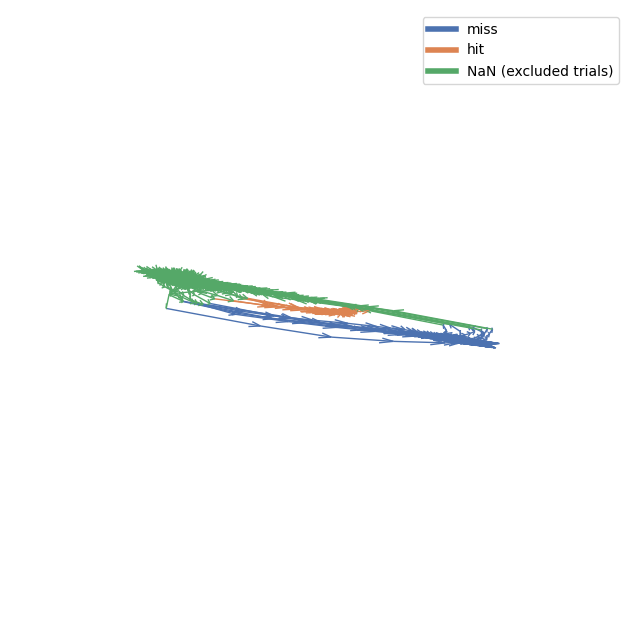

<Axes3D: >

In [169]:
### Run to produce rotating 3-D plot
#%matplotlib notebook
rotating_plot(
    Y0_, 
    R_,
    filename='figures/rotation_stimulus_data_Yresp'+ algorithm + '_worm_'+str(worm_num) +'.gif', 
    state_names=data.response_names,
    legend=True
)

### Performing PCA on the latent dimension (to check if there are redundant or correlated components)


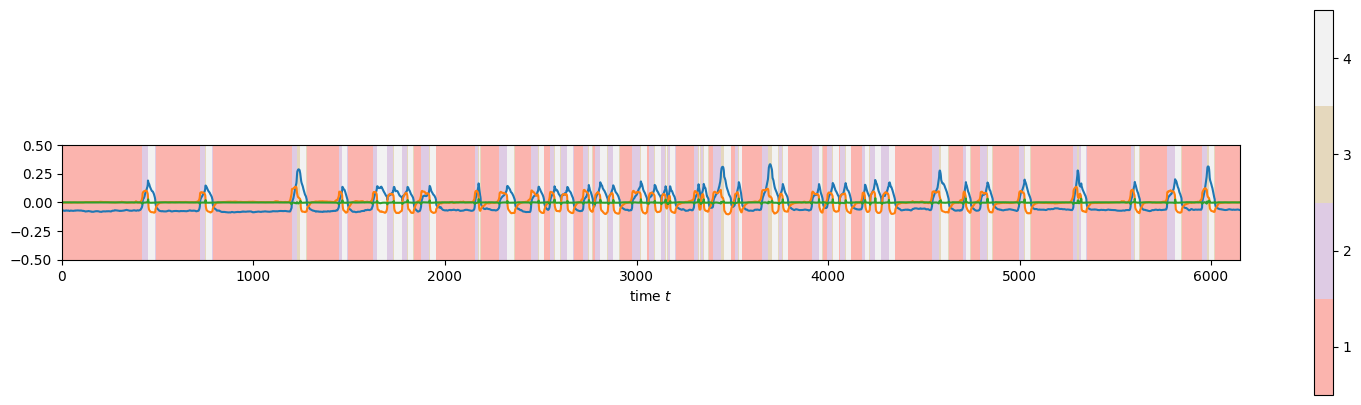

In [18]:
from sklearn.decomposition import PCA
pca = PCA()
Y_pca = pca.fit_transform(Y0_)
plot_latent_timeseries(Y_pca, B_, data.state_names)